Over / Under with Nested Models

    - Last time, we explored the calibration of the individual team runs scored models

    - We observed some degree of mis-calibration: over-predicting the probability of low runs scored, under-predicting the probability of high runs scored

    - However, these discrepancies did not seem large enough to explain the high degree of miscalibration in the overall model

    - Concluded that the independence assumption must be flawed

    - In this notebook, we use nested modeling to predict the total runs scored

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import structureboost as stb
import ml_insights as mli
import scipy as sp

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
# How unlikely is it that we would get 197 (or fewer) successes in 342 trials if the success probability is .7?

.7*(194+148)

239.39999999999998

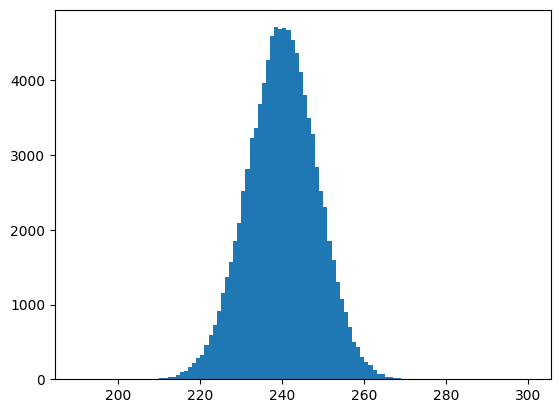

In [3]:
plt.hist(np.random.binomial(n=(194+148), p=.7, size=100000), bins=np.linspace(190,300,111));

In [4]:
df = pd.read_csv('df_bp9.csv', low_memory=False)

df_runs = pd.read_csv('df_runs_bp11.csv', low_memory=False)

In [5]:
df.over_under_line.max()

15.0

In [6]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],16)

Nested Modeling

    - Idea: use the outputs of one model as the inputs to a second model

    - Want to use the predicted distributions (and the over / under line) to predict probability of over / under (rather than relying on the independence assumption)

    - Problem: If we use our previous runs scored model and apply it to the training data, the predictions will be overconfident (or otherwise weird)

    - Need predicted distributions on the training set that are "credible" (i.e. predictions from a model that did not see that point in the training set)

    - We will use cross-validation to get these values.

    - We will create folds based on time.

In [7]:
fold_dict = {}
fold_dict[1970]=-1
for i in range(1971,2018,5):
    fold_dict[i]=0
for i in range(1972,2018,5):
    fold_dict[i]=1
for i in range(1973,2018,5):
    fold_dict[i]=2
for i in range(1974,2018,5):
    fold_dict[i]=3
for i in range(1975,2018,5):
    fold_dict[i]=4
fold_dict[2018] = 5 # validation set
for i in range(2018,2023):
    fold_dict[i]=6 # test set
df_runs['foldnum1'] = df_runs.season.apply(lambda x: fold_dict[x])

In [8]:
pd.crosstab(df_runs.season, df_runs.foldnum1)

foldnum1,-1,0,1,2,3,4,6
season,,,,,,,
1970,3888,0,0,0,0,0,0
1971,0,3874,0,0,0,0,0
1972,0,0,3718,0,0,0,0
1973,0,0,0,3886,0,0,0
1974,0,0,0,0,3890,0,0
1975,0,0,0,0,0,3868,0
1976,0,3878,0,0,0,0,0
1977,0,0,4206,0,0,0,0
1978,0,0,0,4204,0,0,0


In [9]:
df_runs.shape

(232092, 159)

In [10]:
df_runs.iloc[:5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
0,1970,19700406,0,197004060,WS2,DET,AL,AL,0.0,NaN,WAS10,D,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.262702,0.244266,0.261798,0.245791,0.338739,0.322035,0.338695,0.324118,0.394825,0.363500,0.392347,0.365242,0.733564,0.685536,0.731041,0.689360,0.364310,0.376972,0.365211,0.376176,0.146619,0.170586,0.147911,0.168707,0.267313,0.245760,0.266452,0.247721,0.342759,0.318749,0.342771,0.321810,0.391202,0.357365,0.390137,0.360702,0.733961,0.676114,0.732908,0.682512,0.342746,0.340960,0.344454,0.342728,0.130900,0.145244,0.131845,0.144275,0.261027,0.238197,0.260954,0.241031,0.335281,0.307287,0.335944,0.311442,0.389124,0.353090,0.389167,0.357706,0.724405,0.660376,0.725110,0.669148,0.346366,0.327429,0.347829,0.331155,0.133906,0.134460,0.134516,0.134940,0.230243,0.207518,0.228410,0.208750,0.294839,0.266365,0.293402,0.268685,0.341378,0.306780,0.339530,0.309508,0.636217,0.573145,0.632933,0.578193,0.318284,0.291967,0.318138,0.295178,0.134130,0.126369,0.133713,0.126979,3.923077,1.320513,0.214286,0.306548,0.431548,3.615385,0.839286,3.174505,1.206683,0.232950,0.287865,0.385297,2.680693,0.639504,3.123067,1.149966,0.227472,0.277642,0.379445,2.693342,0.650268,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1,0,-1
1,1970,19700406,0,197004060,CIN,MON,NL,NL,0.0,NaN,CIN07,D,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202226,0.194571,0.209172,0.201816,0.240675,0.234767,0.248363,0.2424

In [11]:
df_runs.iloc[116046:116051,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
116046,1970,19700406,0,197004060,WS2,DET,AL,AL,0.0,NaN,WAS10,D,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.273113,0.252291,0.273903,0.255650,0.354892,0.334219,0.355997,0.337843,0.448976,0.411788,0.450139,0.417563,0.803868,0.746007,0.806137,0.755406,0.381514,0.401172,0.382899,0.399925,0.112694,0.149234,0.113295,0.145135,0.248346,0.232296,0.247370,0.233453,0.330695,0.313793,0.330275,0.315560,0.404813,0.374985,0.403396,0.377495,0.735508,0.688778,0.733670,0.693055,0.361831,0.377183,0.362155,0.375525,0.114681,0.144928,0.115014,0.141386,0.244286,0.229831,0.242482,0.230039,0.319016,0.305202,0.317343,0.305446,0.399064,0.369813,0.396224,0.370964,0.718080,0.675015,0.713566,0.676410,0.356743,0.371186,0.355336,0.368081,0.118219,0.147365,0.117794,0.143278,0.234905,0.216900,0.232566,0.217075,0.309194,0.291347,0.306895,0.291538,0.389238,0.355196,0.385994,0.356592,0.698432,0.646543,0.692889,0.648130,0.358996,0.361489,0.357445,0.359771,0.121880,0.141195,0.121292,0.138210,2.520000,0.893333,0.135417,0.232639,0.305556,2.333333,0.607639,2.063415,0.975610,0.133583,0.249688,0.335830,2.580488,0.660424,2.844985,1.118541,0.121622,0.276276,0.374625,3.161094,0.780781,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,0,5,-1
116047,1970,19700406,0,197004060,CIN,MON,NL,NL,0.0,NaN,CIN07,D,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222893,0.211090,0.226459,0.215809,0.305604,0.286463,0.310

In [12]:
df_train = df_runs[(df_runs.season>1970) & (df_runs.season<=2017)]
df_valid = df_runs[(df_runs.season>=2018) & (df_runs.season<=2018)]
df_test = df_runs[df_runs.season>=2019]

df_test_game = df[df.season>=2019]

In [13]:
df_train.shape, df_valid.shape, df_test.shape

((206990, 159), (4856, 159), (16358, 159))

In [14]:
df_train.shape[0] /2,  df_valid.shape[0]/2, df_test.shape[0]/2

(103495.0, 2428.0, 8179.0)

In [15]:
df_train.iloc[:5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
1944,1971,19710405,0,197104050,WS2,OAK,AL,AL,0.0,NaN,WAS10,D,8,0.221680,0.294066,0.312500,0.606566,27.0,10.0,9.0,0.238462,0.317801,0.358242,0.676043,116.0,72.0,42.0,0.212426,0.203975,0.209765,0.202645,0.291862,0.276017,0.288682,0.275158,0.305678,0.286865,0.303281,0.287091,0.597541,0.562882,0.591962,0.562249,0.326223,0.328119,0.322455,0.324475,0.140057,0.160979,0.136813,0.155392,0.224020,0.211721,0.221723,0.211210,0.304482,0.288688,0.301513,0.288014,0.344292,0.319371,0.341590,0.320097,0.648774,0.608058,0.643103,0.608111,0.338597,0.347872,0.334917,0.343371,0.125433,0.151900,0.123010,0.146350,0.216066,0.202004,0.214200,0.202105,0.296567,0.276990,0.294040,0.277195,0.329373,0.303750,0.327491,0.305306,0.625941,0.580740,0.621531,0.582501,0.330040,0.323205,0.327546,0.321821,0.126986,0.138254,0.125261,0.135264,0.203104,0.185140,0.201997,0.186423,0.271510,0.247533,0.270036,0.249248,0.308665,0.279448,0.307971,0.282534,0.580175,0.526981,0.578007,0.531781,0.295205,0.276214,0.293743,0.277306,0.112838,0.112047,0.111415,0.110862,3.724138,1.034483,0.227979,0.259067,0.409326,2.896552,0.725389,4.587302,1.290476,0.179524,0.307952,0.454524,4.359924,1.089981,4.807407,1.402222,0.190444,0.341044,0.452111,4.441031,1.110258,1.147059,0.132530,0.313253,0.385542,1.265060,0.116923,0.323077,0.406154,1.223881,0.143401,0.312183,0.403553,1,8,0
1945,1971,19710405,0,197104050,CIN,ATL,NL,NL,0.0,NaN,CIN08,D,4,0.249255,0.310219,0.

In [16]:
df_train.iloc[103495:103495+5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
117990,1971,19710405,0,197104050,WS2,OAK,AL,AL,0.0,NaN,WAS10,D,0,0.257286,0.347749,0.403015,0.750764,24.0,32.0,16.0,0.248884,0.322483,0.391927,0.714410,141.0,131.0,68.0,0.252795,0.230262,0.252680,0.233021,0.359870,0.330996,0.359082,0.333953,0.390051,0.359675,0.392691,0.365918,0.749922,0.690671,0.751773,0.699871,0.427006,0.412895,0.426462,0.414196,0.166820,0.168655,0.164685,0.166494,0.255034,0.228919,0.255943,0.233058,0.342978,0.309314,0.342943,0.313559,0.384778,0.347210,0.387221,0.354189,0.727756,0.656524,0.730164,0.667748,0.396453,0.365736,0.395072,0.368392,0.165148,0.154947,0.163496,0.154751,0.253870,0.226691,0.255119,0.231272,0.341641,0.305739,0.342060,0.310678,0.406353,0.363604,0.408684,0.371140,0.747995,0.669342,0.750744,0.681818,0.413937,0.374117,0.411958,0.377389,0.162951,0.148617,0.160875,0.148564,0.255885,0.227929,0.257196,0.232665,0.342437,0.305340,0.342969,0.310534,0.410267,0.365793,0.411940,0.372954,0.752704,0.671134,0.754908,0.683488,0.416625,0.373191,0.413095,0.375521,0.165683,0.149020,0.162696,0.148439,2.958904,1.068493,0.142361,0.270833,0.368056,2.616438,0.663194,2.951256,1.187592,0.141304,0.291304,0.408696,3.332349,0.817391,2.605086,1.108452,0.136490,0.275209,0.378273,3.071803,0.762674,1.563830,0.124031,0.379845,0.472868,1.448276,0.127883,0.352201,0.467505,1.433234,0.138798,0.351913,0.460109,0,0,0
117991,1971,19710405,0,197104050,CIN,ATL,NL,NL,0.0,NaN,CIN08,D,7,0.276760,0.336

In [17]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_TB_BB_perc_35',
 'Strt_H_BB_perc_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_TB_BB_perc_75',
 'Bpen_H_BB_perc_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35',
 'Bpen_TB_BB_perc_35',
 'Bpen_H_BB_perc_35',
 'Bpen_SO_perc_35',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']

In [18]:
bpv2 = np.linspace(-.5,16.5,18)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5])

In [19]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

Now, we will do "nested" prediction to create the run distribution values

In [20]:
run_dist_train = np.zeros((df_train.shape[0], 17))

In [21]:
# Loop to get cross-validated predictions on the training set
# *** CAN TAKE 60-90 MINUTES TO LOOP THROUGH ALL 5 TIMES ***

model_list = []
preds_list = []
for fn in range(5):
    tr_mask = df_train.foldnum1!=fn
    te_mask = df_train.foldnum1==fn
    X_tr = df_train.loc[tr_mask,feat_set]
    X_te = df_train.loc[te_mask,feat_set]
    y_tr = df_train[target][tr_mask]
    y_te = df_train[target][te_mask]
    model_list.append(stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2))
    model_list[fn].fit(X_tr, y_tr, eval_set=(X_te, y_te), early_stop_past_steps=5, eval_freq=10)
    run_dist_train[te_mask,:] = model_list[fn].predict_distributions(X_te).probmat

i=0, eval_set_loss = 2.4387408425167956
i=10, eval_set_loss = 2.43456982798224
i=20, eval_set_loss = 2.4314515988520693
i=30, eval_set_loss = 2.4290454126635805
i=40, eval_set_loss = 2.4271648520232953
i=50, eval_set_loss = 2.4256754844168444
i=60, eval_set_loss = 2.4245377030586264
i=70, eval_set_loss = 2.423514062984708
i=80, eval_set_loss = 2.422604393586521
i=90, eval_set_loss = 2.421892267485686
i=100, eval_set_loss = 2.4213108225169737
i=110, eval_set_loss = 2.420806153172177
i=120, eval_set_loss = 2.42043846511262
i=130, eval_set_loss = 2.4201020178564647
i=140, eval_set_loss = 2.419808761427271
i=150, eval_set_loss = 2.41959057909399
i=160, eval_set_loss = 2.4193818836505274
i=170, eval_set_loss = 2.419253815414534
i=180, eval_set_loss = 2.419118977347474
i=190, eval_set_loss = 2.419018868328708
i=200, eval_set_loss = 2.4189341915768443
i=210, eval_set_loss = 2.418878128392092
i=220, eval_set_loss = 2.418781911265625
i=230, eval_set_loss = 2.418728066605222
i=240, eval_set_loss

In [22]:
# Redo previous approach to get predictions on valid, test sets

cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', structured_loss=False,
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)


i=0, eval_set_loss = 2.4493166949503222
i=10, eval_set_loss = 2.4463545518948933
i=20, eval_set_loss = 2.4444685333800686
i=30, eval_set_loss = 2.442975286443446
i=40, eval_set_loss = 2.441878586512062
i=50, eval_set_loss = 2.4410761506286667
i=60, eval_set_loss = 2.4405700653534277
i=70, eval_set_loss = 2.4399860640882065
i=80, eval_set_loss = 2.439739530039983
i=90, eval_set_loss = 2.439343304146739
i=100, eval_set_loss = 2.4389876332355604
i=110, eval_set_loss = 2.438902481484091
i=120, eval_set_loss = 2.4388289476949714
i=130, eval_set_loss = 2.4387275672487942
i=140, eval_set_loss = 2.4387395769967024
i=150, eval_set_loss = 2.4389222875407093
i=160, eval_set_loss = 2.4387909138607102
i=170, eval_set_loss = 2.4387898611001146
i=180, eval_set_loss = 2.4387582204170553
Stopping early: low pt was 5 steps ago


In [23]:
run_dist_valid = cr1.predict_distributions(X_valid).probmat
run_dist_test = cr1.predict_distributions(X_test).probmat

In [24]:
cr1.predict_distributions(X_test).log_loss(y_test)

2.449941779733465

In [25]:
run_cdf_train = np.cumsum(run_dist_train, axis=1)[:,:-1]
run_cdf_valid = np.cumsum(run_dist_valid, axis=1)[:,:-1]
run_cdf_test = np.cumsum(run_dist_test, axis=1)[:,:-1]

In [26]:
result_probs = np.array([run_dist_train[i,y_train[i]] for i in range(len(y_train))])

In [27]:
-np.mean(np.log(result_probs))

2.420622329628475

In [28]:
run_cdf_train1 = run_cdf_train[:103495,:]
run_cdf_train2 = run_cdf_train[103495:,:]
run_cdf_valid1 = run_cdf_valid[:2428,:]
run_cdf_valid2 = run_cdf_valid[2428:,:]
run_cdf_test1 = run_cdf_test[:8179,:]
run_cdf_test2 = run_cdf_test[8179:,:]

run_train_team1 = y_train[:103495]
run_train_team2 = y_train[103495:]
run_valid_team1 = y_valid[:2428]
run_valid_team2 = y_valid[2428:]
run_test_team1 = y_test[:8179]
run_test_team2 = y_test[8179:]

run_total_train = run_train_team1 + run_train_team2
run_total_valid = run_valid_team1 + run_valid_team2
run_total_test = run_test_team1 + run_test_team2

run_total_train = np.minimum(run_total_train, 16)
run_total_valid = np.minimum(run_total_valid, 16)
run_total_test = np.minimum(run_total_test, 16)

base_cols = ['rd'+str(i) for i in range(16)]
cn1 = [cn+'_h' for cn in base_cols]
cn2 = [cn+'_v' for cn in base_cols]
cn_list = cn1+cn2

In [29]:
X_train_nested = pd.DataFrame(np.hstack((run_cdf_train1, run_cdf_train2)))
X_valid_nested = pd.DataFrame(np.hstack((run_cdf_valid1, run_cdf_valid2)))
X_test_nested = pd.DataFrame(np.hstack((run_cdf_test1, run_cdf_test2)))

X_train_nested.columns = cn1+cn2
X_valid_nested.columns = cn1+cn2
X_test_nested.columns = cn1+cn2

In [30]:
run_cdf_train1.shape, run_cdf_train2.shape, X_train_nested.shape

((103495, 16), (103495, 16), (103495, 32))

In [31]:
X_train_nested.sample(10)

,rd0_h,rd1_h,rd2_h,rd3_h,rd4_h,rd5_h,rd6_h,rd7_h,rd8_h,rd9_h,rd10_h,rd11_h,rd12_h,rd13_h,rd14_h,rd15_h,rd0_v,rd1_v,rd2_v,rd3_v,rd4_v,rd5_v,rd6_v,rd7_v,rd8_v,rd9_v,rd10_v,rd11_v,rd12_v,rd13_v,rd14_v,rd15_v
65099,0.040536,0.121450,0.236909,0.370797,0.504941,0.628621,0.730468,0.808205,0.867640,0.910179,0.941258,0.962996,0.977560,0.986632,0.992162,0.995250,0.033522,0.099256,0.192305,0.307472,0.425382,0.537429,0.644362,0.732178,0.801013,0.856729,0.898870,0.931378,0.953339,0.969288,0.979860,0.987022
48598,0.047695,0.138877,0.259959,0.398393,0.533001,0.655740,0.756328,0.834320,0.889434,0.927436,0.952778,0.970273,0.981606,0.989023,0.993316,0.996209,0.050388,0.141933,0.261812,0.394823,0.522210,0.641650,0.738366,0.815914,0.873578,0.914543,0.943396,0.963541,0.976436,0.985465,0.990760,0.994625
43844,0.074666,0.196623,0.351009,0.507936,0.646172,0.757784,0.840729,0.899298,0.937133,0.961965,0.977144,0.986263,0.991869,0.995135,0.997172,0.998444,0.069466,0.186481,0.327575,0.471603,0.605970,0.716052,0.803474,0.868884,0.912674,0.944074,0.965554,0.978685,0.987681,0.992610,0.995920,0.997747
24828,0.058369,0.164190,0.297285,0.446720,0.590719,0.706953,0.798249,0.866822,0.913811,0.944941,0.966108,0.979579,0.988116,0.992696,0.995608,0.997512,0.049923,0.145567,0.268625,0.408540,0.542679,0.659708,0.755120,0.829957,0.885047,0.923926,0.951018,0.968708,0.981083,0.988129,0.992870,0.995836
91389,0.093821,0.248586,0.408143,0.560790,0.689380,0.786166,0.859269,0.909765,0.943747,0.964756,0.978233,0.986534,0.992289,0.995649,0.997519,0.998489,0.132281,0.321061,0.518814,0.672936,0.789727,0.863115,0.912614,0.945132,0.966194,0.978468,0.986763,0.991939,0.995354,0.997301,0.998461,0.999030
95375,0.034689,0.108122,0.209490,0.336435,0.467868,0.589034,0.699614,0.782955,0.847048,0.893955,0.928817,0.953457,0.970484,0.981546,0.988486,0.992937,0.086887,0.219919,0.379211,0.532046,0.657236,0.755382,0.830896,0.886984,0.925196,0.950486,0.967757,0.979008,0.987378,0.992728,0.995528,0.997236
4287,0.066040,0.175497,0.317247,0.465220,0.604338,0.725871,0.816450,0.881204,0.922960,0.950758,0.968610,0.980146,0.988155,0.992708,0.995578,0.997446,0.101447,0.244638,0.409555,0.564679,0.688917,0.787657,0.860084,0.911019,0.944679,0.966480,0.979325,0.987274,0.992865,0.995706,0.997718,0.998734
56997,0.050598,0.147169,0.273505,0.416912,0.556095,0.676405,0.772728,0.845670,0.897866,0.933239,0.957604,0.973295,0.983678,0.989568,0.993265,0.996172,0.045483,0.133069,0.246039,0.377835,0.507515,0.624294,0.723990,0.802153,0.862933,0.906620,0.938210,0.959873,0.975040,0.984300,0.990433,0.994241
30631,0.054962,0.155243,0.286189,0.434091,0.568442,0.686796,0.780684,0.849166,0.899273,0.932940,0.956801,0.973084,0.983705,0.990077,0.994131,0.996497,0.079023,0.206238,0.362464,0.506002,0.636765,0.741238,0.821398,0.881839,0.921275,0.949743,0.970211,0.981851,0.989485,0.993545,0.996190,0.997743
17096,0.070368,0.183366,0.325356,0.476457,0.608295,0.719301,0.809995,0.875117,0.919713,0.950076,0.968490,0.980262,0.988488,0.993356,0.996169,0.997965,0.052708,0.148127,0.272675,0.411629,0.546116,0.662051,0.758918,0.835053,0.889875,0.927837,0.954113,0.970901,0.982398,0.989098,0.993163,0.996167


In [32]:
cr_final = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', structured_loss=False,
               binpt_vec=bpv2)
cr_final.fit(X_train_nested, run_total_train, eval_set=(X_valid_nested, run_total_valid), early_stop_past_steps=5,)

i=0, eval_set_loss = 2.6823929120808523
i=10, eval_set_loss = 2.680824663588917
i=20, eval_set_loss = 2.679937201962025
i=30, eval_set_loss = 2.6793863502718036
i=40, eval_set_loss = 2.6790932986764266
i=50, eval_set_loss = 2.6790984879773734
i=60, eval_set_loss = 2.6789583400621497
i=70, eval_set_loss = 2.6789995244920917
i=80, eval_set_loss = 2.678902934664118
i=90, eval_set_loss = 2.6788333152167807
i=100, eval_set_loss = 2.6789809660796213
i=110, eval_set_loss = 2.6791851384448138
i=120, eval_set_loss = 2.679300614412173
i=130, eval_set_loss = 2.6793677481107245
i=140, eval_set_loss = 2.6795279163145675
Stopping early: low pt was 5 steps ago


In [33]:
final_test_dists = cr_final.predict_distributions(X_test_nested)

In [34]:
final_test_dists.log_loss(run_total_test)

2.664854499396855

In [35]:
start_test_dists = cr_final.predict_distributions(X_test_nested, num_trees_to_use=1)
start_test_dists.log_loss(run_total_test)

2.673017201295559

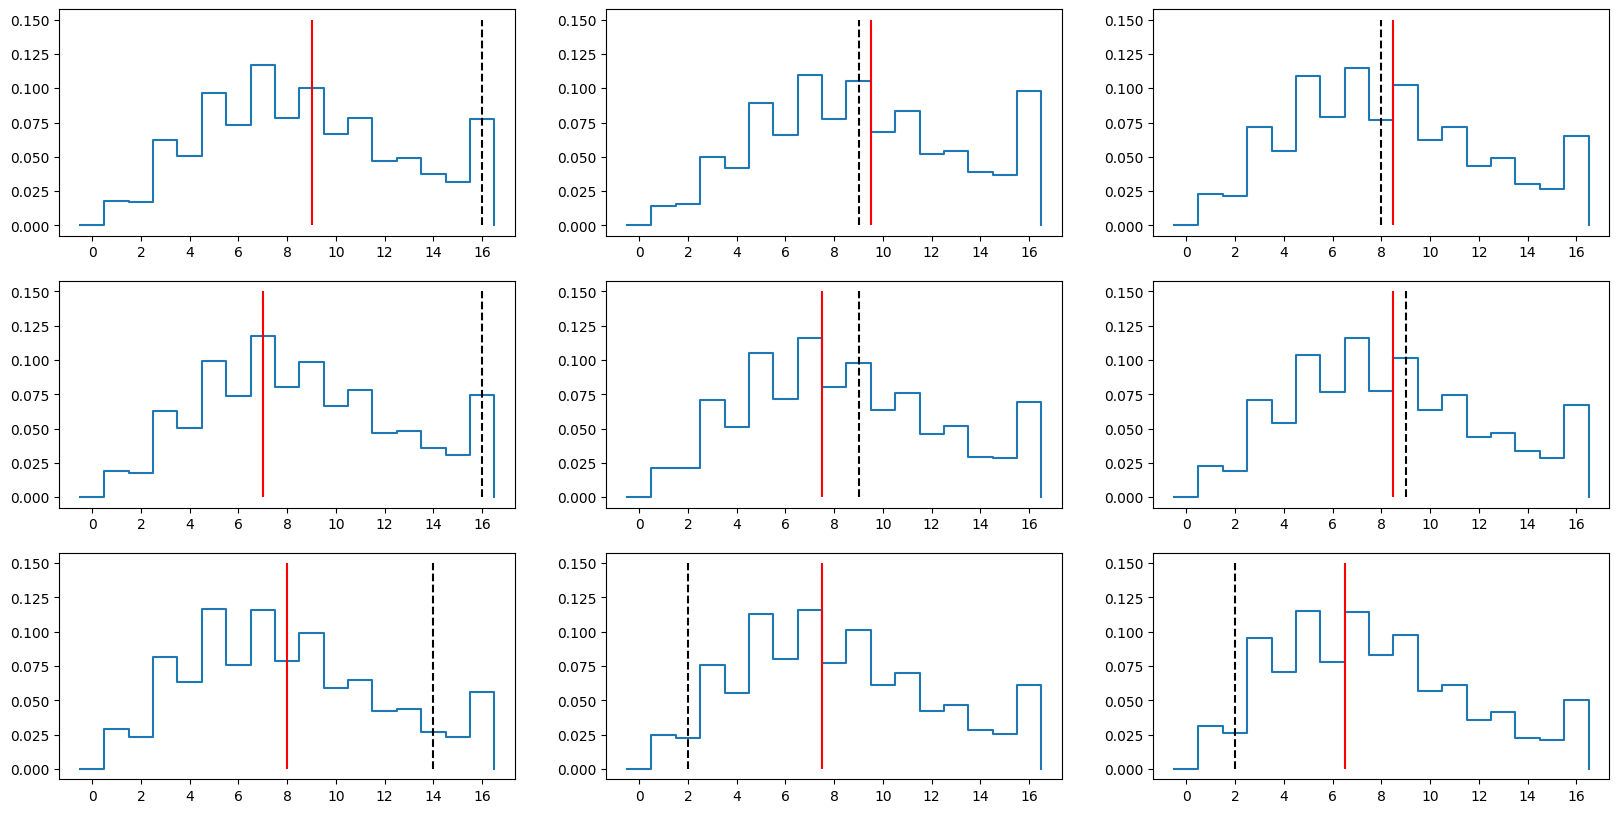

In [36]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    final_test_dists[i].plot_density()
    plt.vlines(run_total_test[i],ymin=0,ymax=.15, color='k', linestyle='--')
    plt.vlines(df_test_game.over_under_line.iloc[i],ymin=0,ymax=.15, color='red')
    plt.xticks(np.linspace(0,16,9))

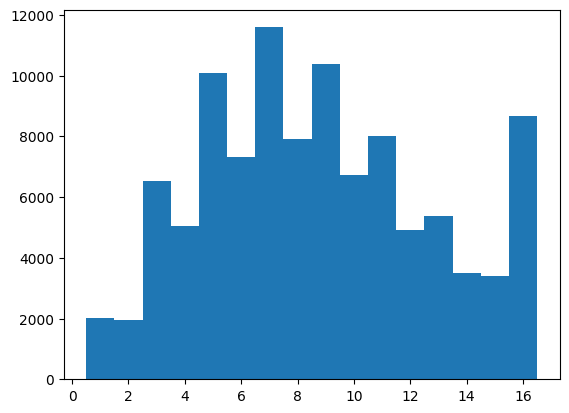

In [37]:
plt.hist(run_total_train, bins=np.linspace(0.5, 16.5, 17));

In [44]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(df_test_game.over_under_line.iloc[i]))]) 
                    for i in range(len(run_total_test))])

In [45]:
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(df_test_game.over_under_line.iloc[i]+1)):]) 
                    for i in range(len(run_total_test))])

In [46]:
push_probs_test = 1-under_probs_test-over_probs_test

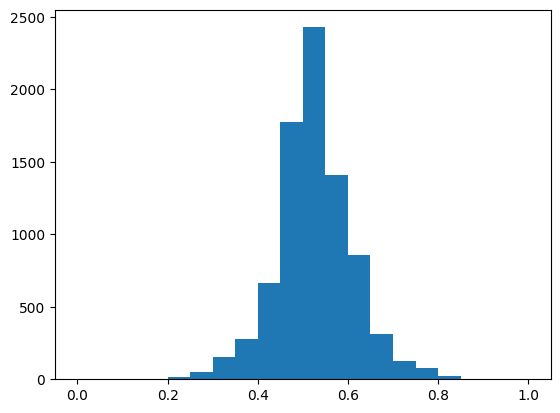

In [47]:
plt.hist(under_probs_test, bins=np.linspace(0,1,21));

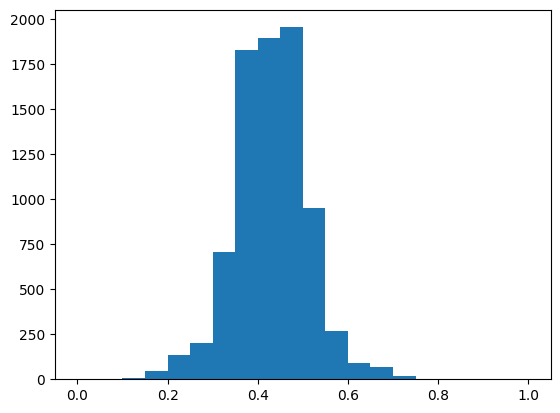

In [48]:
plt.hist(over_probs_test, bins=np.linspace(0,1,21));

Examine Calibration of Over/Under Predictions

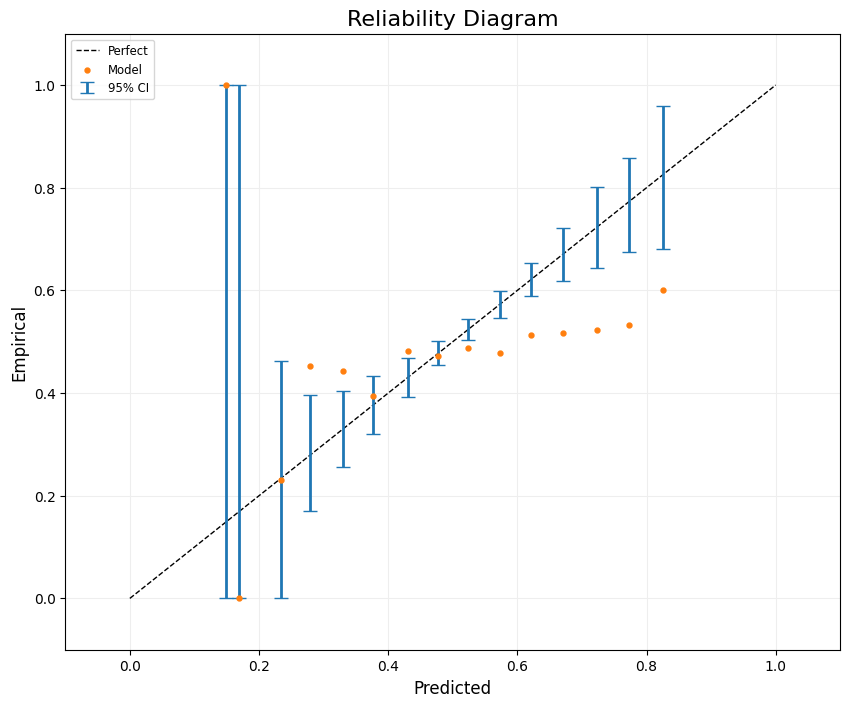

In [49]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((df_test_game.over_under_result=='U').astype(int), under_probs_test, np.linspace(0,1,21));
#plt.ylim([.3,.7])

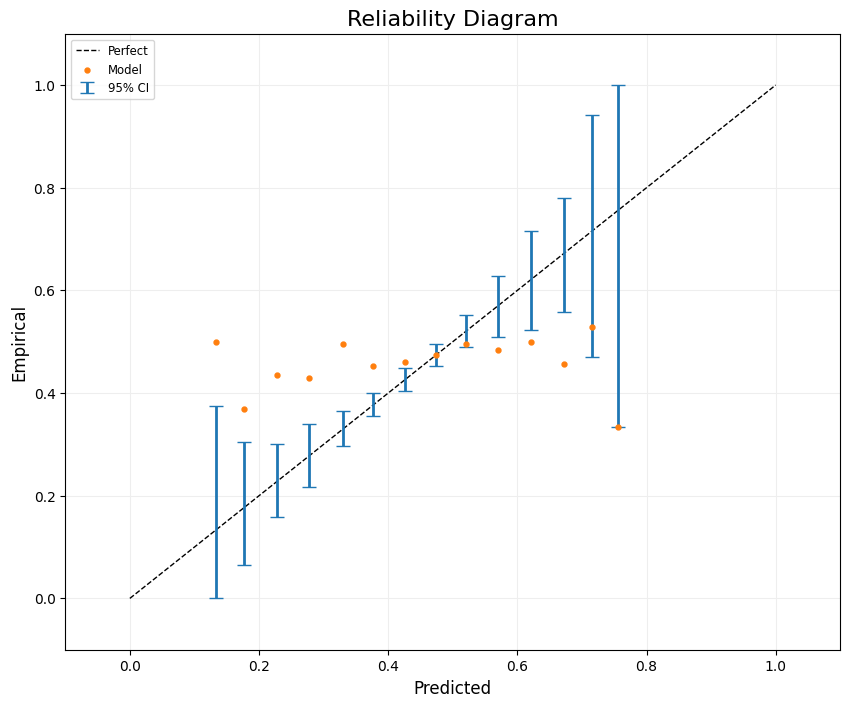

In [50]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((df_test_game.over_under_result=='O').astype(int), over_probs_test, np.linspace(0,1,21));

ValueError: 'yerr' must not contain negative values

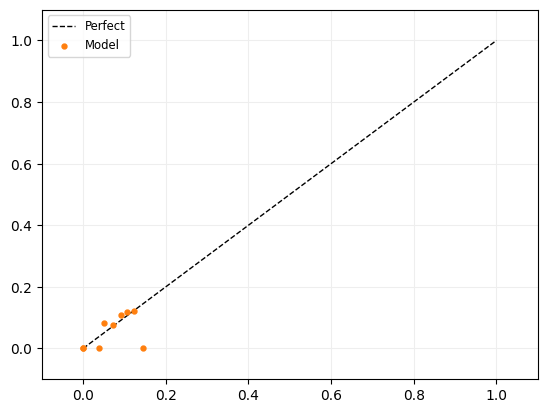

In [52]:
mli.plot_reliability_diagram((df_test_game.over_under_result=='P').astype(int), push_probs_test, np.linspace(0,1,51));
plt.xlim([0,.2])
plt.ylim([0,.2])

In [53]:
def evaluate_edge_probs(oupmat, edge, test_df_w_ouline):
    bet_under = (oupmat[:,1]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    bet_over = (oupmat[:,0]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    num_cases_under = np.sum(bet_under)
    num_cases_over = np.sum(bet_over)
    num_cases_total = num_cases_under + num_cases_over
    num_under_correct = (test_df_w_ouline.loc[bet_under,'over_under_result']=='U').sum()
    num_under_push = (test_df_w_ouline.loc[bet_under,'over_under_result']=='P').sum()
    num_over_correct = (test_df_w_ouline.loc[bet_over,'over_under_result']=='O').sum()
    num_over_push = (test_df_w_ouline.loc[bet_over,'over_under_result']=='P').sum()
    num_correct = num_under_correct + num_over_correct
    num_pushes = num_under_push + num_over_push
    num_incorrect = num_cases_total -num_correct - num_pushes
    pct_correct = num_correct / num_cases_total
    pct_pushes = num_pushes / num_cases_total
    pct_incorrect = num_incorrect / num_cases_total
    pct_under_correct = num_under_correct/num_cases_under
    pct_under_push = num_under_push/num_cases_under
    pct_over_correct = num_over_correct/num_cases_over
    pct_over_push = num_over_push/num_cases_over
    print(f'\nThere were {num_cases_total} games that met criteria of edge > {edge} ({num_cases_under} unders and {num_cases_over} overs)')
    print(f'Of them {num_correct} ({np.round(pct_correct,3)}) were correct (winning bets), ({num_under_correct} unders and {num_over_correct} overs) ')
    print(f'and {num_pushes} ({np.round(pct_pushes,3)}) were Pushes ({num_under_push} unders and {num_over_push} overs)')
    print(f'and {num_incorrect} ({np.round(pct_incorrect,3)}) were incorrect (losing bets))')
    winning_edge_m110 = pct_correct*1 + pct_incorrect*(-1.1)
    win_total_m110 = num_correct*1 + num_incorrect*(-1.1)
    print(f'Betting the Under at a line of -110, your profit would have been {np.round(winning_edge_m110,4)} per bet')
    print(f'\t for a total profit of {np.round(win_total_m110,2)} across all {num_cases_total} bets')
    print('\n')

In [54]:
oup_probs = np.vstack((over_probs_test, under_probs_test, push_probs_test)).T

In [55]:
for i in np.linspace(.25, .05,5):
    print(f'threshold = {i}')
    evaluate_edge_probs(oup_probs, i, df_test_game)

threshold = 0.25

There were 156 games that met criteria of edge > 0.25 (148 unders and 8 overs)
Of them 86 (0.551) were correct (winning bets), (82 unders and 4 overs) 
and 8 (0.051) were Pushes (6 unders and 2 overs)
and 62 (0.397) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.1141 per bet
	 for a total profit of 17.8 across all 156 bets


threshold = 0.2

There were 365 games that met criteria of edge > 0.2 (321 unders and 44 overs)
Of them 194 (0.532) were correct (winning bets), (171 unders and 23 overs) 
and 16 (0.044) were Pushes (12 unders and 4 overs)
and 155 (0.425) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.0644 per bet
	 for a total profit of 23.5 across all 365 bets


threshold = 0.15

There were 874 games that met criteria of edge > 0.15 (747 unders and 127 overs)
Of them 442 (0.506) were correct (winning bets), (382 unders and 60 overs) 
and 35 (0.04) were Pushes (28 

Calibration with respect to fixed values

In [56]:
df_test_game.over_under_line.mean()

8.656926274605697

In [57]:
line = 8.5

In [58]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(line))]) 
                    for i in range(len(run_total_test))])

In [59]:
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(line))+1:]) 
                    for i in range(len(run_total_test))])

In [60]:
push_probs_test = 1-under_probs_test-over_probs_test

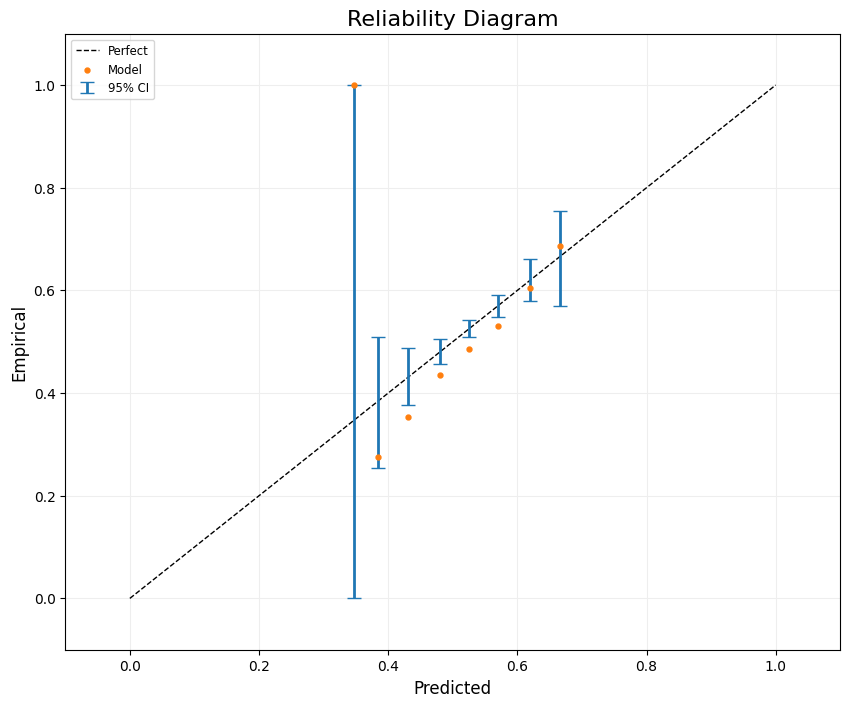

In [61]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test<line).astype(int), under_probs_test, np.linspace(0,1,21));

(0.1, 0.9)

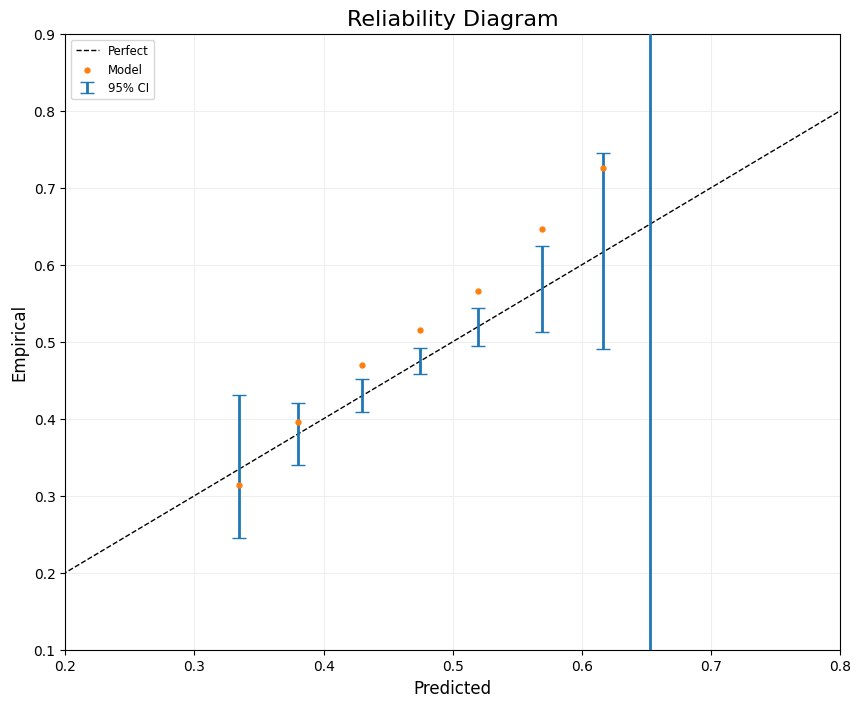

In [62]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test>line).astype(int), over_probs_test, np.linspace(0,1,21));
plt.xlim([.2,.8])
plt.ylim([.1,.9])

Calibration with respect to randomly chosen line

(array([378., 403., 385., 392., 405., 382., 366., 366., 394., 426., 381.,
        406., 386., 392., 339., 387., 414., 366., 400., 398., 413.]),
 array([ 4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
         9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
        13.75, 14.25, 14.75, 15.25]),
 <BarContainer object of 21 artists>)

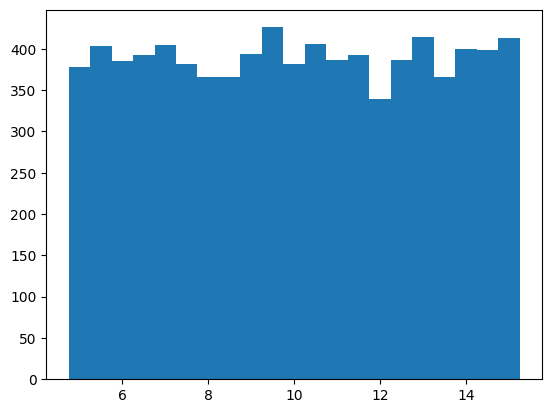

In [63]:
line = np.random.randint(10,31,size=len(run_total_test))/2
plt.hist(line, bins=np.linspace(4.75,15.25,22))

In [64]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(line[i]))]) 
                    for i in range(len(run_total_test))])

In [65]:
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(line[i]))+1:]) 
                    for i in range(len(run_total_test))])

In [66]:
push_probs_test = 1-under_probs_test-over_probs_test

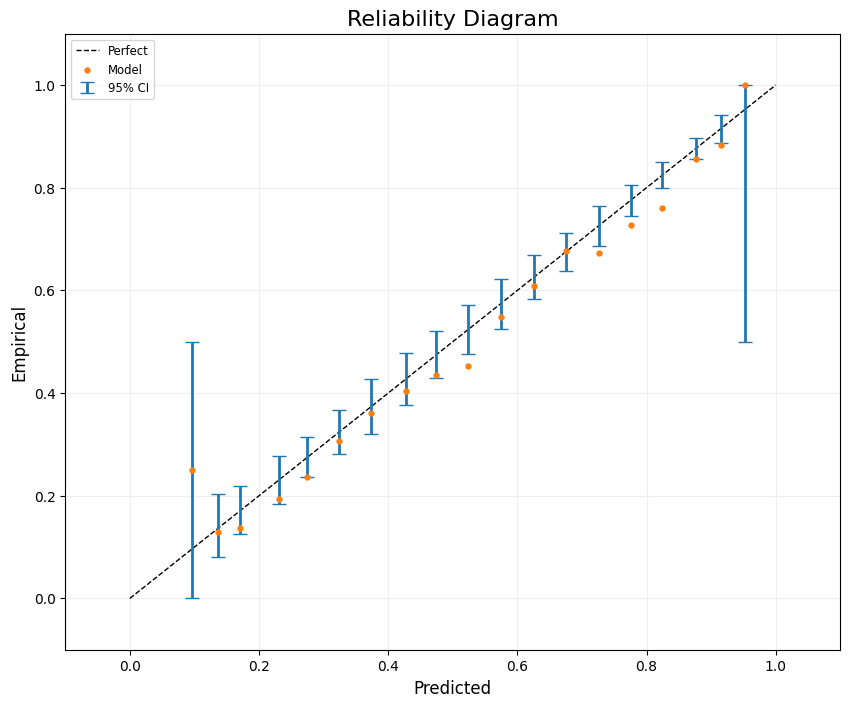

In [67]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test<line).astype(int), under_probs_test, np.linspace(0,1,21));

(0.1, 0.9)

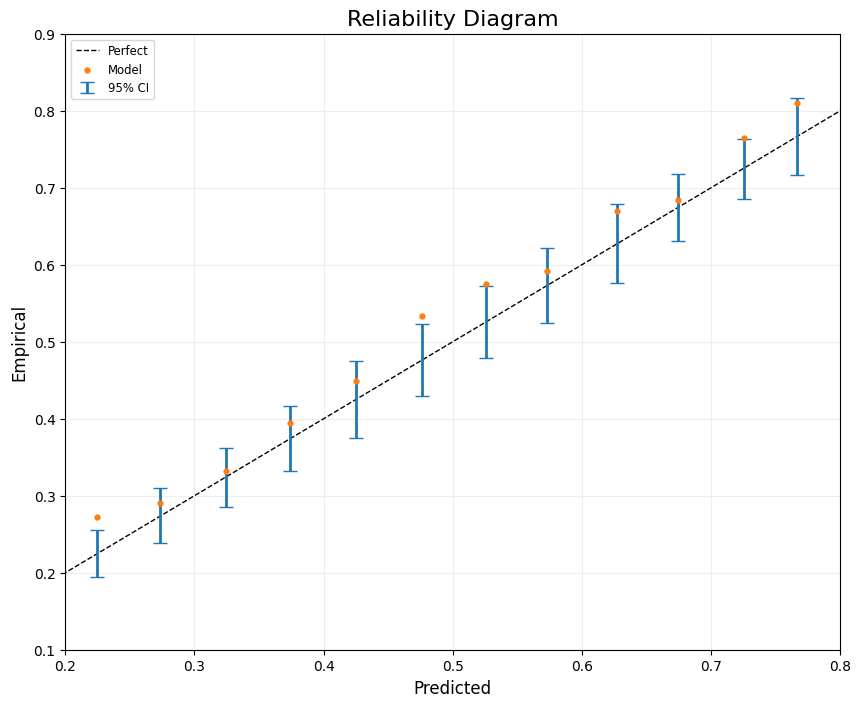

In [68]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test>line).astype(int), over_probs_test, np.linspace(0,1,21));
plt.xlim([.2,.8])
plt.ylim([.1,.9])

Conclusions

    - The information inherent in the Vegas line is likely the primary source of the overall miscalibration

    - Model tends to over-predict low scores and under-predict high scores.
        -- This is seen in both the individual team runs scored model and the combined model

    - Independence assumption seems less of a problem than before (could do more direct comparison)

Next Steps

    - Could try to dive deeper into the causes / solutions for the overprediction of low runs scored
        -- Might just be model drift
        -- Calibration / Conformal Prediction techniques will only help if there is a "good" data set to calibrate to

    - Predict run differential using similar techniques

    - Use all of the above to better predict the moneyline